# Cube and Data Warehouse

In [1]:
import atoti as tt

Welcome to Atoti 0.8.10!

By using this community edition, you agree with the license available at https://docs.atoti.io/latest/eula.html.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

Atoti collects telemetry data, which is used to help understand how to improve the product.
If you don't wish to send usage data, you can request a trial license at https://www.atoti.io/evaluation-license-request.

You can hide this message by setting the `ATOTI_HIDE_EULA_MESSAGE` environment variable to True.


In [2]:
session = tt.Session(
    user_content_storage=".content",
    port=9092,
    java_options=["-Xms1G", "-Xmx10G"]
)

In [3]:
db_name = "olympic_olap"
db_user = "postgres"
db_password = "postgres"  
db_host = "pgdb"  # Update if your DB is hosted elsewhere
db_port = "5432"

jdbc_url = f"jdbc:postgresql://{db_host}:{db_port}/{db_name}?user={db_user}&password={db_password}"

In [4]:
# # Load the combined fact table from the database into the Atoti session.
# This table aggregates various metrics across multiple dimensions including sports, economic indicators, 
# and health data for comprehensive analysis.

combined_fact_table = session.read_sql(
    """
    SELECT
        id,
        game_slug,
        participant_id,
        athlete_id,
        event_id,
        country_code,
        CAST(year AS CHAR(4)) AS year,  -- Casting year to string directly in SQL
        total_bronze_medals,
        total_silver_medals,
        total_gold_medals,
        total_medals,
        poverty_count,
        gdp_per_capita,
        annual_gdp_growth,
        servers_count,
        daly_depression,
        daly_schizophrenia,
        daly_bipolar_disorder,
        daly_eating_disorder,
        daly_anxiety,
        life_expectancy,
        infant_mortality_rate,
        current_health_expenditure,
        government_health_expenditure,
        private_health_expenditure,
        external_health_expenditure
    FROM combinedfacttable
    """,
    keys=["id"],
    table_name="CombinedFactTable",
    url=jdbc_url,
)

In [5]:
# # Load the dimension table for location data from the database into the Atoti session. 
# This table includes geographic details indexed by country code to enhance analytical capabilities by providing spatial context.

dimlocation_table = session.read_sql(
    "SELECT * FROM DimLocation",
    keys=["country_code"],
    table_name="DimLocation",
    url=jdbc_url)

In [6]:
# Load the dimension table for event data from the database into the Atoti session. 

dimevent_table = session.read_sql(
    "SELECT * FROM DimEvent",
    keys=["event_id"],
    table_name="DimEvent",
    url=jdbc_url,
)

In [7]:
# Load the dimension table for participant data from the database into the Atoti session. 

dimparticipant_table = session.read_sql(
    "SELECT * FROM DimParticipant",
    keys=["participant_id"],
    table_name="DimParticipant",
    url=jdbc_url,
)

In [8]:
# Load the dimension table for athlete data from the database into the Atoti session. 

dimathlete_table = session.read_sql(
    "SELECT * FROM DimAthlete",
    keys=["athlete_id"],
    table_name="DimAthlete",
    url=jdbc_url,
)

In [9]:
# Load the dimension table for year data from the database into the Atoti session. 

dimyear_table = session.read_sql(
    "SELECT CAST(year AS CHAR(4)) AS year FROM DimYear",
    keys=["year"],
    table_name="DimYear",
    url=jdbc_url,
)

In [10]:
# Load the dimension table for game data from the database into the Atoti session. 

dimgame_table = session.read_sql(
    "SELECT * FROM DimGame",
    keys=["game_slug"],
    table_name="DimGame",
    url=jdbc_url,
)

In [11]:
# Join the combined fact table with various dimension tables to enrich the dataset with additional contextual information.
# This will facilitate more detailed and comprehensive analysis across multiple dimensions.

combined_fact_table.join(dimlocation_table, combined_fact_table["country_code"] == dimlocation_table["country_code"])

combined_fact_table.join(dimevent_table, combined_fact_table["event_id"] == dimevent_table["event_id"])

combined_fact_table.join(dimparticipant_table, combined_fact_table["participant_id"] == dimparticipant_table["participant_id"])

combined_fact_table.join(dimathlete_table, combined_fact_table["athlete_id"] == dimathlete_table["athlete_id"])

combined_fact_table.join(dimyear_table, combined_fact_table["year"] == dimyear_table["year"])

combined_fact_table.join(dimgame_table, combined_fact_table["game_slug"] == dimgame_table["game_slug"])

In [12]:
combined_fact_table['year']

In [13]:
session.tables.schema

```mermaid
erDiagram
  "DimAthlete" {
    _ int PK "athlete_id"
    _ String "athlete_name"
    _ String "athlete_url"
  }
  "DimLocation" {
    _ String PK "country_code"
    _ String "country_name"
    _ String "continent"
  }
  "DimEvent" {
    _ int PK "event_id"
    _ String "event_title"
    _ String "event_discipline"
    _ String "event_gender"
  }
  "CombinedFactTable" {
    _ int PK "id"
    _ String "game_slug"
    nullable int "participant_id"
    nullable int "athlete_id"
    nullable int "event_id"
    _ String "country_code"
    _ String "year"
    nullable int "total_bronze_medals"
    nullable int "total_silver_medals"
    nullable int "total_gold_medals"
    nullable int "total_medals"
    nullable double "poverty_count"
    nullable double "gdp_per_capita"
    nullable double "annual_gdp_growth"
    nullable int "servers_count"
    nullable double "daly_depression"
    nullable double "daly_schizophrenia"
    nullable double "daly_bipolar_disorder"
    nullable double "daly_eating_disorder"
    nullable double "daly_anxiety"
    nullable double "life_expectancy"
    nullable double "infant_mortality_rate"
    nullable double "current_health_expenditure"
    nullable double "government_health_expenditure"
    nullable double "private_health_expenditure"
    nullable double "external_health_expenditure"
  }
  "DimParticipant" {
    _ int PK "participant_id"
    _ String "participant_title"
    _ String "participant_type"
  }
  "DimYear" {
    _ String PK "year"
  }
  "DimGame" {
    _ String PK "game_slug"
    _ String "game_name"
    _ String "game_season"
    nullable int "game_year"
    _ String "country_code"
  }
  "CombinedFactTable" }o--o| "DimLocation" : "`country_code` == `country_code`"
  "CombinedFactTable" }o--o| "DimGame" : "`game_slug` == `game_slug`"
  "CombinedFactTable" }o--o| "DimParticipant" : "`participant_id` == `participant_id`"
  "CombinedFactTable" }o--o| "DimYear" : "`year` == `year`"
  "CombinedFactTable" }o--o| "DimAthlete" : "`athlete_id` == `athlete_id`"
  "CombinedFactTable" }o--o| "DimEvent" : "`event_id` == `event_id`"
```


In [14]:
# Create a cube from the combined fact table in the Atoti session.
# This cube will allow for multi-dimensional analysis and visualization of the data aggregated in the fact table, 
# facilitating deeper insights and easier exploration.

cube = session.create_cube(combined_fact_table)

In [15]:
cube

In [16]:
hierarchies, levels, measures = cube.hierarchies, cube.levels, cube.measures

In [17]:
hierarchies

{('CombinedFactTable', 'country_code'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c6550>, ('CombinedFactTable', 'id'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c6990>, ('DimParticipant', 'participant_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c6f50>, ('DimAthlete', 'athlete_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c7110>, ('DimGame', 'game_season'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c7250>, ('CombinedFactTable', 'game_slug'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c7390>, ('DimParticipant', 'participant_type'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c76d0>, ('DimEvent', 'event_discipline'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c7c90>, ('CombinedFactTable', 'year'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c7f10>, ('DimEvent', 'event_gender'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c7d90>, ('DimLocation', 'country_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c5fd0>, ('DimAthlete', 'athlete_url'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c7610>, ('DimEvent', 'event_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c7b50>, ('DimGame', 'game_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c78d0>, ('DimLocation', 'continent'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c7750>, ('DimGame', 'country_code'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c6dd0>}

In [18]:
hierarchies["Year"] = [dimyear_table["year"]]

In [19]:
hierarchies

{('CombinedFactTable', 'country_code'): <atoti.hierarchy.Hierarchy object at 0x7fffb04ddc50>, ('CombinedFactTable', 'id'): <atoti.hierarchy.Hierarchy object at 0x7fffb050f110>, ('DimParticipant', 'participant_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb050e4d0>, ('DimAthlete', 'athlete_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb050f6d0>, ('DimGame', 'game_season'): <atoti.hierarchy.Hierarchy object at 0x7fffb0511190>, ('CombinedFactTable', 'game_slug'): <atoti.hierarchy.Hierarchy object at 0x7fffb0510e50>, ('DimParticipant', 'participant_type'): <atoti.hierarchy.Hierarchy object at 0x7fffb0510c90>, ('DimEvent', 'event_discipline'): <atoti.hierarchy.Hierarchy object at 0x7fffb0510a10>, ('CombinedFactTable', 'year'): <atoti.hierarchy.Hierarchy object at 0x7fffb05108d0>, ('DimEvent', 'event_gender'): <atoti.hierarchy.Hierarchy object at 0x7fffb05124d0>, ('DimYear', 'Year'): <atoti.hierarchy.Hierarchy object at 0x7fffb0512350>, ('DimLocation', 'country_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb05110d0>, ('DimAthlete', 'athlete_url'): <atoti.hierarchy.Hierarchy object at 0x7fffb0510210>, ('DimEvent', 'event_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb0512250>, ('DimGame', 'game_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb0511bd0>, ('DimLocation', 'continent'): <atoti.hierarchy.Hierarchy object at 0x7fffb0511b90>, ('DimGame', 'country_code'): <atoti.hierarchy.Hierarchy object at 0x7fffb0512050>}

In [20]:
# List all hierarchies in the cube to find the correct name
for hierarchy in hierarchies:
    print(hierarchy)


('CombinedFactTable', 'country_code')
('CombinedFactTable', 'id')
('DimParticipant', 'participant_title')
('DimAthlete', 'athlete_name')
('DimGame', 'game_season')
('CombinedFactTable', 'game_slug')
('DimParticipant', 'participant_type')
('DimEvent', 'event_discipline')
('CombinedFactTable', 'year')
('DimEvent', 'event_gender')
('DimYear', 'Year')
('DimLocation', 'country_name')
('DimAthlete', 'athlete_url')
('DimEvent', 'event_title')
('DimGame', 'game_name')
('DimLocation', 'continent')
('DimGame', 'country_code')


In [21]:
# Remove unwanted hierarchy
del hierarchies[('CombinedFactTable', 'country_code')]
del hierarchies[('CombinedFactTable', 'id')]
del hierarchies[('CombinedFactTable', 'game_slug')]
del hierarchies[('CombinedFactTable', 'year')]

In [22]:
hierarchies

{('DimParticipant', 'participant_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb04ddb10>, ('DimAthlete', 'athlete_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb0512510>, ('DimGame', 'game_season'): <atoti.hierarchy.Hierarchy object at 0x7fffb0511090>, ('DimParticipant', 'participant_type'): <atoti.hierarchy.Hierarchy object at 0x7fffb0512cd0>, ('DimEvent', 'event_discipline'): <atoti.hierarchy.Hierarchy object at 0x7fffb0512310>, ('DimEvent', 'event_gender'): <atoti.hierarchy.Hierarchy object at 0x7fffb0513950>, ('DimYear', 'Year'): <atoti.hierarchy.Hierarchy object at 0x7fffb0510190>, ('DimLocation', 'country_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb0513d10>, ('DimAthlete', 'athlete_url'): <atoti.hierarchy.Hierarchy object at 0x7fffb05130d0>, ('DimEvent', 'event_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb0535a10>, ('DimGame', 'game_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb0537790>, ('DimLocation', 'continent'): <atoti.hierarchy.Hierarchy object at 0x7fffb0537f90>, ('DimGame', 'country_code'): <atoti.hierarchy.Hierarchy object at 0x7fffb0534210>}

In [23]:
levels

In [24]:
# Define new hierarchies`

hierarchies["DimAthlete"] = [levels["athlete_name"]]

hierarchies["DimEvent"] = [levels["event_title"], levels[("DimEvent", "event_discipline", "event_discipline")],
                           levels[("DimEvent", "event_gender", "event_gender")]]

hierarchies["DimGame"] = [levels["game_name"], levels[("DimGame", "game_season", "game_season")]]

hierarchies["DimLocation"]  = [levels["country_name"], levels[("DimLocation", "continent", "continent")]]

hierarchies["DimParticipant"] = [levels["participant_title"], levels[("DimParticipant", "participant_type", "participant_type")]]

hierarchies["DimYear"] = [levels["year"]]


In [25]:
# Delete unnecessary hierarchy

del hierarchies[("DimAthlete", "athlete_name")]

del hierarchies[('DimAthlete', 'athlete_url')]

del hierarchies[('DimEvent', 'event_gender')]
del hierarchies[('DimEvent', 'event_title')]
del hierarchies[('DimEvent', 'event_discipline')]

del hierarchies[('DimGame', 'game_season')]
del hierarchies[('DimGame', 'country_code')]
del hierarchies[('DimGame', 'game_name')]

del hierarchies[('DimLocation', 'country_name')]
del hierarchies[('DimLocation', 'continent')]


del hierarchies[('DimParticipant', 'participant_title')]
del hierarchies[('DimParticipant', 'participant_type')]

del hierarchies[('DimYear', 'Year')]

In [26]:
hierarchies

{('DimParticipant', 'DimParticipant'): <atoti.hierarchy.Hierarchy object at 0x7fffb0535d10>, ('DimLocation', 'DimLocation'): <atoti.hierarchy.Hierarchy object at 0x7fffb0484550>, ('DimYear', 'DimYear'): <atoti.hierarchy.Hierarchy object at 0x7fffb0485690>, ('DimGame', 'DimGame'): <atoti.hierarchy.Hierarchy object at 0x7ffffc179010>, ('DimEvent', 'DimEvent'): <atoti.hierarchy.Hierarchy object at 0x7fffb0534910>, ('DimAthlete', 'DimAthlete'): <atoti.hierarchy.Hierarchy object at 0x7fffb0536150>}

In [27]:
measures


{'contributors.COUNT': <atoti.measure.Measure object at 0x7fffb04c6250>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x7fffb04c5bd0>, 'total_silver_medals.SUM': <atoti.measure.Measure object at 0x7fffb04c6d90>, 'total_silver_medals.MEAN': <atoti.measure.Measure object at 0x7fffb04c5f10>, 'participant_id.SUM': <atoti.measure.Measure object at 0x7fffb04c6310>, 'participant_id.MEAN': <atoti.measure.Measure object at 0x7fffb04c7f50>, 'annual_gdp_growth.SUM': <atoti.measure.Measure object at 0x7fffb04c7810>, 'annual_gdp_growth.MEAN': <atoti.measure.Measure object at 0x7fffb04c6d10>, 'total_gold_medals.SUM': <atoti.measure.Measure object at 0x7fffb04c7cd0>, 'total_gold_medals.MEAN': <atoti.measure.Measure object at 0x7fffb04c4090>, 'daly_schizophrenia.SUM': <atoti.measure.Measure object at 0x7fffb04c57d0>, 'daly_schizophrenia.MEAN': <atoti.measure.Measure object at 0x7fffb04c56d0>, 'total_bronze_medals.SUM': <atoti.measure.Measure object at 0x7fffb04c4b90>, 'total_bronze_medals.MEAN': <atoti.measure.Measure object at 0x7fffb04c55d0>, 'athlete_id.SUM': <atoti.measure.Measure object at 0x7fffb04c5950>, 'athlete_id.MEAN': <atoti.measure.Measure object at 0x7fffb04c4c50>, 'daly_bipolar_disorder.SUM': <atoti.measure.Measure object at 0x7fffb04c4590>, 'daly_bipolar_disorder.MEAN': <atoti.measure.Measure object at 0x7fffb04c4750>, 'external_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb04c4710>, 'external_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb04c4790>, 'infant_mortality_rate.SUM': <atoti.measure.Measure object at 0x7fffb04c4690>, 'infant_mortality_rate.MEAN': <atoti.measure.Measure object at 0x7fffb04c7d90>, 'government_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb04c41d0>, 'government_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb04c4a90>, 'servers_count.SUM': <atoti.measure.Measure object at 0x7fffb04c6810>, 'servers_count.MEAN': <atoti.measure.Measure object at 0x7fffb04c7e50>, 'event_id.SUM': <atoti.measure.Measure object at 0x7fffb04c5450>, 'event_id.MEAN': <atoti.measure.Measure object at 0x7fffb04c6a50>, 'current_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb04c7e90>, 'current_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb04c5810>, 'poverty_count.SUM': <atoti.measure.Measure object at 0x7fffb04c5890>, 'poverty_count.MEAN': <atoti.measure.Measure object at 0x7fffb04c6450>, 'total_medals.SUM': <atoti.measure.Measure object at 0x7fffb04c5a10>, 'total_medals.MEAN': <atoti.measure.Measure object at 0x7fffb04c5750>, 'daly_anxiety.SUM': <atoti.measure.Measure object at 0x7fffb04c5c50>, 'daly_anxiety.MEAN': <atoti.measure.Measure object at 0x7fffb04c6c50>, 'gdp_per_capita.SUM': <atoti.measure.Measure object at 0x7fffb04c5d90>, 'gdp_per_capita.MEAN': <atoti.measure.Measure object at 0x7fffb04c5cd0>, 'life_expectancy.SUM': <atoti.measure.Measure object at 0x7fffb04c6dd0>, 'life_expectancy.MEAN': <atoti.measure.Measure object at 0x7fffb04c48d0>, 'daly_eating_disorder.SUM': <atoti.measure.Measure object at 0x7fffb04c6b90>, 'daly_eating_disorder.MEAN': <atoti.measure.Measure object at 0x7fffb04c5390>, 'private_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb04c5290>, 'private_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb04c4650>, 'daly_depression.SUM': <atoti.measure.Measure object at 0x7fffb04c5550>, 'daly_depression.MEAN': <atoti.measure.Measure object at 0x7fffb04c5250>}

In [28]:
del measures["athlete_id.MEAN"]


del measures["contributors.COUNT"]

del measures["athlete_id.SUM"]

del measures["event_id.MEAN"]

del measures["event_id.SUM"]
del measures["participant_id.MEAN"]
del measures["participant_id.SUM"]

In [29]:
measures

{'update.TIMESTAMP': <atoti.measure.Measure object at 0x7fffb0510b50>, 'total_silver_medals.SUM': <atoti.measure.Measure object at 0x7fffb0513410>, 'total_silver_medals.MEAN': <atoti.measure.Measure object at 0x7fffb0513510>, 'annual_gdp_growth.SUM': <atoti.measure.Measure object at 0x7fffb0511dd0>, 'annual_gdp_growth.MEAN': <atoti.measure.Measure object at 0x7fffb0512a10>, 'total_gold_medals.SUM': <atoti.measure.Measure object at 0x7fffb0510a10>, 'total_gold_medals.MEAN': <atoti.measure.Measure object at 0x7fffb0511850>, 'daly_schizophrenia.SUM': <atoti.measure.Measure object at 0x7fffb0511b90>, 'daly_schizophrenia.MEAN': <atoti.measure.Measure object at 0x7fffb05120d0>, 'total_bronze_medals.SUM': <atoti.measure.Measure object at 0x7fffb0510e90>, 'total_bronze_medals.MEAN': <atoti.measure.Measure object at 0x7fffb0511e10>, 'daly_bipolar_disorder.SUM': <atoti.measure.Measure object at 0x7fffb0510c10>, 'daly_bipolar_disorder.MEAN': <atoti.measure.Measure object at 0x7fffb0511d90>, 'external_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb0510dd0>, 'external_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb0513b50>, 'infant_mortality_rate.SUM': <atoti.measure.Measure object at 0x7fffb05129d0>, 'infant_mortality_rate.MEAN': <atoti.measure.Measure object at 0x7fffb0511a50>, 'government_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb0513690>, 'government_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb0510510>, 'servers_count.SUM': <atoti.measure.Measure object at 0x7fffb0513e90>, 'servers_count.MEAN': <atoti.measure.Measure object at 0x7fffb0511fd0>, 'current_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb0513f90>, 'current_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb0513f10>, 'poverty_count.SUM': <atoti.measure.Measure object at 0x7fffb0512990>, 'poverty_count.MEAN': <atoti.measure.Measure object at 0x7fffb0513d90>, 'total_medals.SUM': <atoti.measure.Measure object at 0x7fffb0510ad0>, 'total_medals.MEAN': <atoti.measure.Measure object at 0x7fffb0511910>, 'daly_anxiety.SUM': <atoti.measure.Measure object at 0x7fffb0513bd0>, 'daly_anxiety.MEAN': <atoti.measure.Measure object at 0x7fffb0513450>, 'gdp_per_capita.SUM': <atoti.measure.Measure object at 0x7fffb0513550>, 'gdp_per_capita.MEAN': <atoti.measure.Measure object at 0x7fffb0513490>, 'life_expectancy.SUM': <atoti.measure.Measure object at 0x7fffb0513d50>, 'life_expectancy.MEAN': <atoti.measure.Measure object at 0x7fffb0511a90>, 'daly_eating_disorder.SUM': <atoti.measure.Measure object at 0x7fffb0513150>, 'daly_eating_disorder.MEAN': <atoti.measure.Measure object at 0x7fffb0510fd0>, 'private_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb0512950>, 'private_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb0511010>, 'daly_depression.SUM': <atoti.measure.Measure object at 0x7fffb0511490>, 'daly_depression.MEAN': <atoti.measure.Measure object at 0x7fffb0510c90>}

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
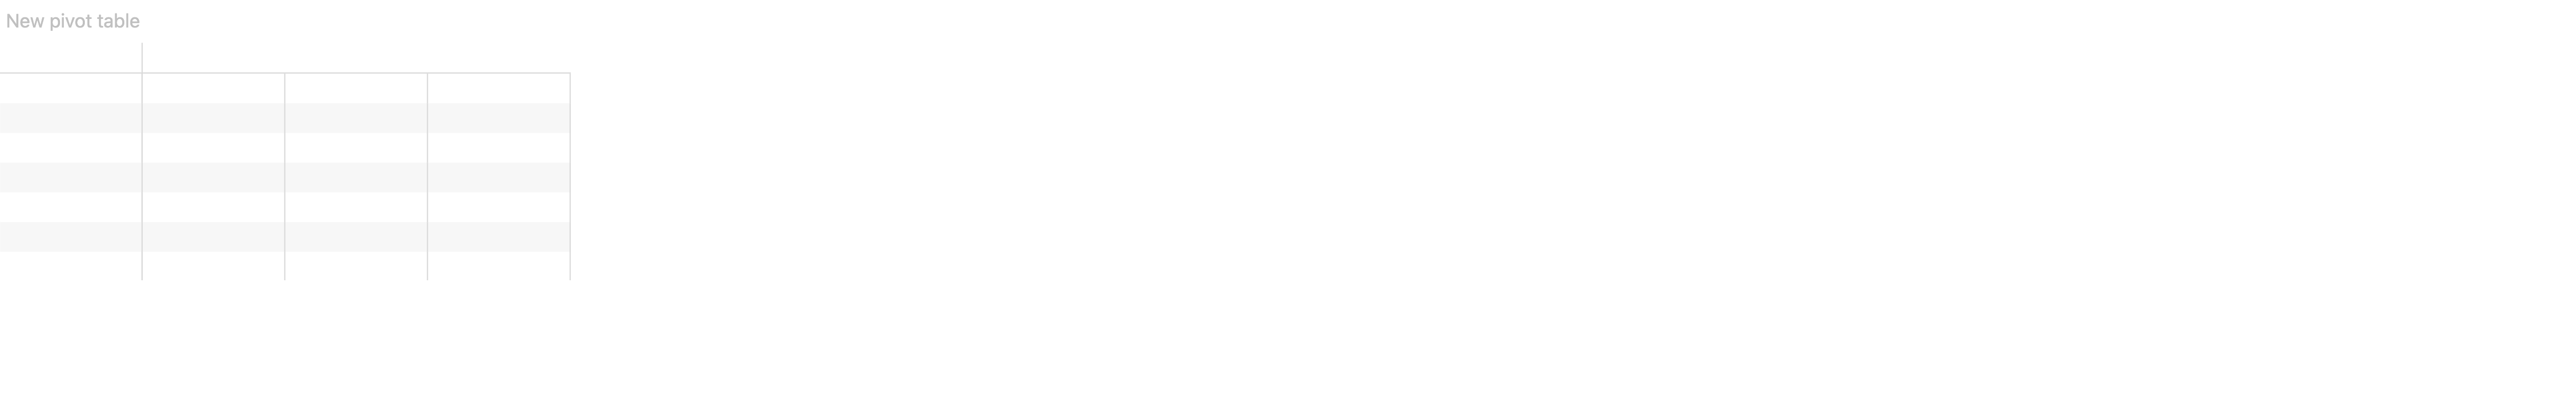

In [30]:
session.widget

In [31]:
session.link

http://localhost:9092

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

In [32]:
# m["Price.VALUE"] = tt.agg.single_value(table["Price"])

# Create new measures for data visualisation. Since, we require data point for each year, I created single value measure for the following

measures["daly_anxiety.VALUE"] = tt.agg.single_value(combined_fact_table["daly_anxiety"])

measures["daly_bipolar_disorder.VALUE"] = tt.agg.single_value(combined_fact_table["daly_bipolar_disorder"])

measures["daly_depression.VALUE"] = tt.agg.single_value(combined_fact_table["daly_depression"])

measures["daly_eating_disorder.VALUE"] = tt.agg.single_value(combined_fact_table["daly_eating_disorder"])

measures["daly_schizophrenia.VALUE"] = tt.agg.single_value(combined_fact_table["daly_schizophrenia"])

measures["life_expectancy.VALUE"] = tt.agg.single_value(combined_fact_table["life_expectancy"])

measures["current_health_expenditure.VALUE"] = tt.agg.single_value(combined_fact_table["current_health_expenditure"])

measures["external_health_expenditure.VALUE"] = tt.agg.single_value(combined_fact_table["external_health_expenditure"])

measures["government_health_expenditure.VALUE"] = tt.agg.single_value(combined_fact_table["government_health_expenditure"])

measures["infant_mortality_rate.VALUE"] = tt.agg.single_value(combined_fact_table["infant_mortality_rate"])

measures["private_health_expenditure.VALUE"] = tt.agg.single_value(combined_fact_table["private_health_expenditure"])

measures["annual_gdp_growth.VALUE"] = tt.agg.single_value(combined_fact_table["annual_gdp_growth"])

measures["poverty_count.VALUE"] = tt.agg.single_value(combined_fact_table["poverty_count"])

The above measure have been used for the visualisation in the report.

In [33]:
measures["servers_count.VALUE"] = tt.agg.single_value(combined_fact_table["servers_count"])